# Initialisation of Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from joblib import dump

# Load the UNSW-NB15 dataset
df_unsw = pd.read_csv('e:/Vishnupriya/Dataset/UNSW-NB15/UNSW_NB15_training-set.csv')

# Display first few rows to check the dataset structure
print(df_unsw.head())

   id       dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0   1  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1   2  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2   3  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3   4  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4   5  0.449454   tcp       -   FIN     10      6     534     268  33.373826   

   ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0  ...                 1               1             0           0   
1  ...                 1               2             0           0   
2  ...                 1               3             0           0   
3  ...                 1               3             1           1   
4  ...                 1              40             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  attack_cat  \
0                 0   

# Correlation Matrix

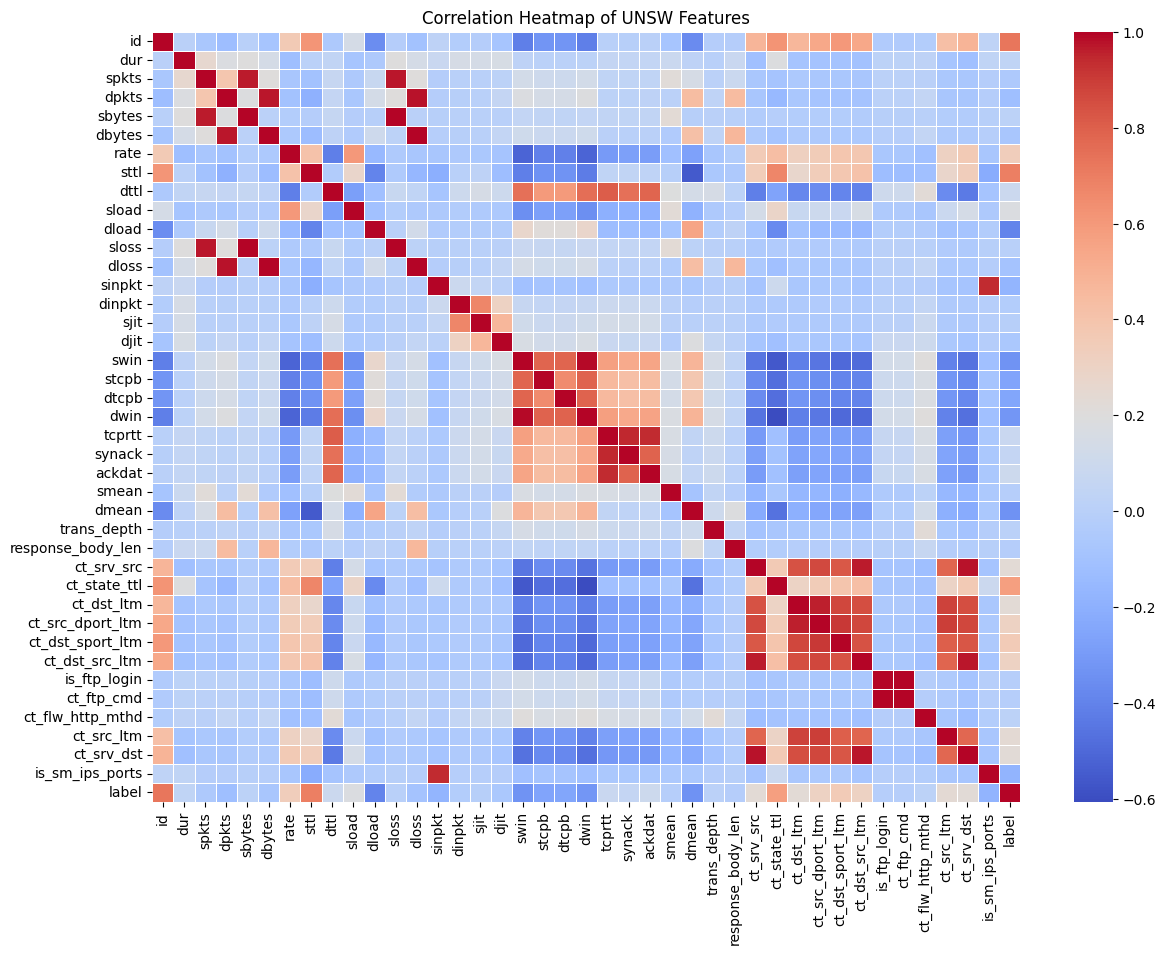

In [2]:
# Correlation matrix for feature selection and visualization
df_unsw_numeric = df_unsw.select_dtypes(include=[float, int])  # Ensure only numeric columns
correlation_matrix = df_unsw_numeric.corr()

# Plotting the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of UNSW Features')
plt.show()

# Data Preprocessing

In [7]:
# Convert 'label' column to binary (1 for attack, 0 for normal)
df_unsw['label'] = df_unsw['label'].apply(lambda x: 1 if x == 1 else 0)

# # Drop unnecessary columns
# df_unsw.drop(['id', 'attack_cat'], axis=1, inplace=True)

# Separate features and labels
X_unsw = df_unsw.drop('label', axis=1)
y_unsw = df_unsw['label']

# Identify categorical and numeric columns
categorical_cols_unsw = ['proto', 'service', 'state']
numeric_cols_unsw = X_unsw.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing pipeline for numeric and categorical columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Ensure OneHotEncoder outputs a dense format
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))  # Changed sparse to sparse_output
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols_unsw),
        ('cat', categorical_transformer, categorical_cols_unsw)
    ])

# Split the dataset into training and testing sets (80% train, 20% test)
X_train_unsw, X_test_unsw, y_train_unsw, y_test_unsw = train_test_split(X_unsw, y_unsw, test_size=0.2, random_state=42)

# After fitting your preprocessing
preprocessor.fit(X_train_unsw)  # Assuming X_train_nsl is your training dataset
dump(preprocessor, 'preprocessor_unsw.joblib')  # Save the fitted preprocessor


['preprocessor_unsw.joblib']

# Evaluation Methods

In [8]:
# Train and evaluate models
def evaluate_model(y_true, y_pred, model_name):
    print(f"Evaluation metrics for {model_name}:")
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    roc_auc = roc_auc_score(y_true, y_pred)
    print(f"ROC AUC Score: {roc_auc:.4f}\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
    plt.title(f"Confusion Matrix for {model_name} on UNSW-NB15")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


# Random Forest Classifier

Evaluation metrics for Random Forest:
Accuracy: 0.9585
Precision: 0.9600
Recall: 0.9799
F1-Score: 0.9698
ROC AUC Score: 0.9462



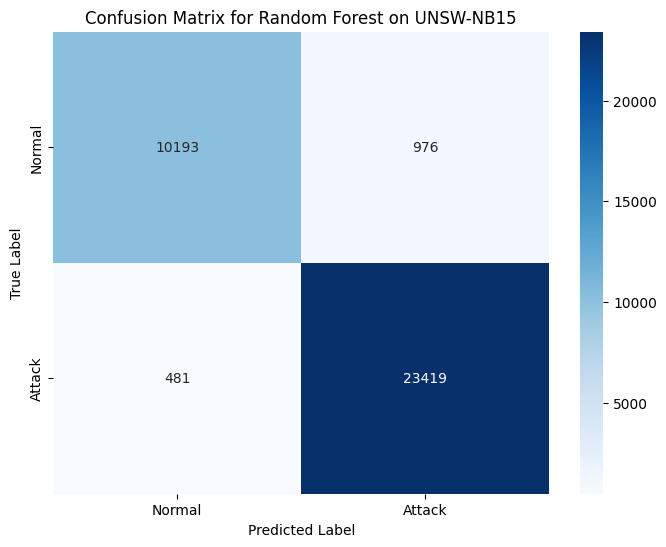

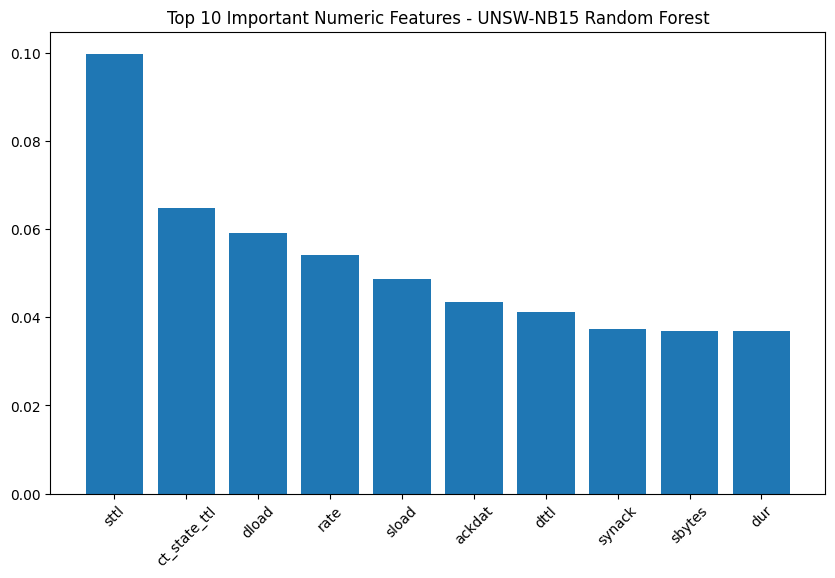

In [9]:
# Random Forest Classifier
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
rf_model.fit(X_train_unsw, y_train_unsw)
y_pred_rf = rf_model.predict(X_test_unsw)

# Save Random Forest model
dump(rf_model, 'rf_model_unsw.joblib')
evaluate_model(y_test_unsw, y_pred_rf, "Random Forest")

# Feature importance from the RandomForest model (numeric features only)
rf_feature = rf_model.named_steps['classifier']
numeric_feature_importances = rf_feature.feature_importances_[:len(numeric_cols_unsw)]
indices = numeric_feature_importances.argsort()[::-1][:10]  # Top 10 important features

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.title("Top 10 Important Numeric Features - UNSW-NB15 Random Forest")
plt.bar(range(len(indices)), numeric_feature_importances[indices], align="center")
plt.xticks(range(len(indices)), [numeric_cols_unsw[i] for i in indices], rotation=45)
plt.show()

# XGBoost Classifier

c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:46:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluation metrics for XGBoost:
Accuracy: 0.9585
Precision: 0.9608
Recall: 0.9791
F1-Score: 0.9699
ROC AUC Score: 0.9468



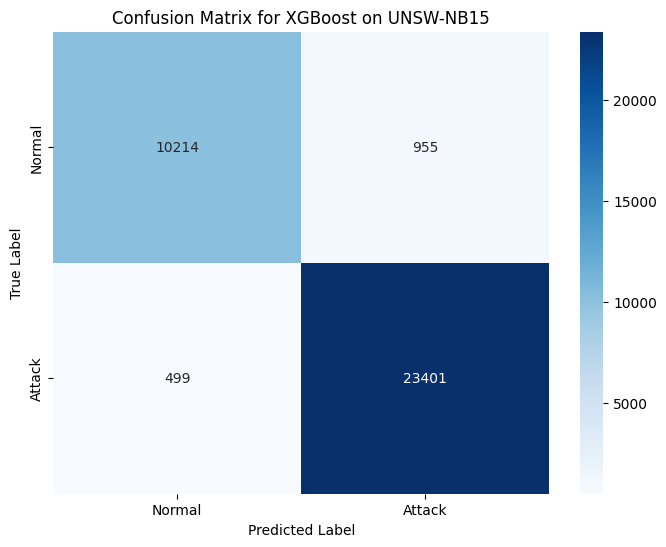

In [10]:
# XGBoost Classifier
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])
xgb_model.fit(X_train_unsw, y_train_unsw)
y_pred_xgb = xgb_model.predict(X_test_unsw)

# Save XGBoost model
dump(xgb_model, 'xgb_model_unsw.joblib')
evaluate_model(y_test_unsw, y_pred_xgb, "XGBoost")


# Isolation Forest

Evaluation metrics for Isolation Forest:
Accuracy: 0.3257
Precision: 0.5363
Recall: 0.0779
F1-Score: 0.1361
ROC AUC Score: 0.4669



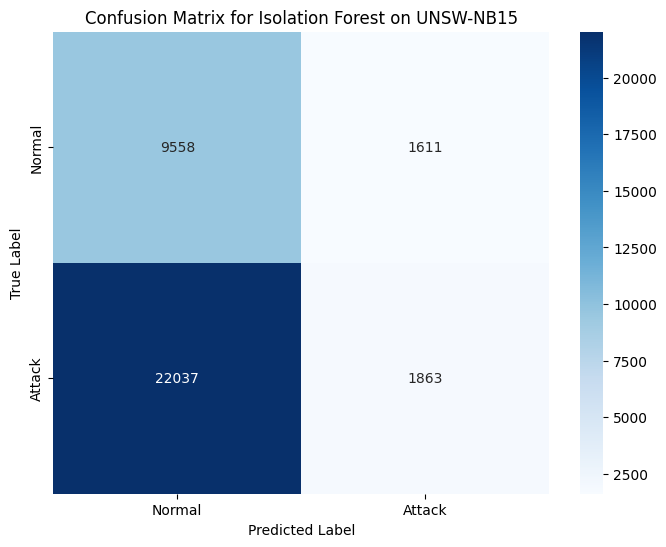

In [11]:
# Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.1, random_state=42)
# Apply preprocessing to training data for Isolation Forest
X_train_iso = preprocessor.fit_transform(X_train_unsw)
X_test_iso = preprocessor.transform(X_test_unsw)

iso_forest.fit(X_train_iso)
y_pred_iso = iso_forest.predict(X_test_iso)
y_pred_iso = [0 if pred == 1 else 1 for pred in y_pred_iso]  # Convert to binary labels

# Save Isolation Forest model
dump(iso_forest, 'iso_forest_model_unsw.joblib')
evaluate_model(y_test_unsw, y_pred_iso, "Isolation Forest")

# Autoencoder

c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 0.1699 - val_loss: 0.1614
Epoch 2/50
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.1539 - val_loss: 0.1603
Epoch 3/50
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.1475 - val_loss: 0.1602
Epoch 4/50
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.1434 - val_loss: 0.1596
Epoch 5/50
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.1478 - val_loss: 0.1594
Epoch 6/50
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.1475 - val_loss: 0.1592
Epoch 7/50
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.1519 - val_loss: 0.1591
Epoch 8/50
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.1462 - val_loss: 0.1581
Epoch 9/50
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.1448 - val_loss: 0.1580
Epoch 10/50
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.1471 - val_loss: 0.1580
Epoch 11/50
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1493 - val_loss: 0.1579
Epoch 12/50
4384/43

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Evaluation metrics for Autoencoder:
Accuracy: 0.3100
Precision: 0.4147
Recall: 0.0304
F1-Score: 0.0567
ROC AUC Score: 0.4693



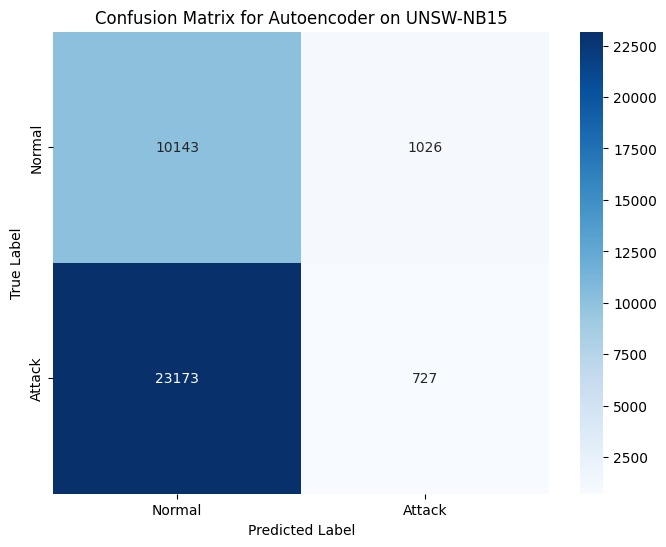

In [26]:
# Autoencoder for anomaly detection
def create_autoencoder(input_dim):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(input_dim,)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(input_dim, activation='sigmoid'))
    return model

# Preprocess the data before training the Autoencoder
X_train_autoencoder = preprocessor.fit_transform(X_train_unsw)
X_test_autoencoder = preprocessor.transform(X_test_unsw)

autoencoder = create_autoencoder(X_train_autoencoder.shape[1])
autoencoder.compile(optimizer='adam', loss='mse')

# Train Autoencoder
autoencoder.fit(X_train_autoencoder, X_train_autoencoder, epochs=50, batch_size=32, shuffle=True, validation_data=(X_test_autoencoder, X_test_autoencoder))

# Save Autoencoder model
autoencoder.save('autoencoder_model_unsw.h5')

# Anomaly detection using Autoencoder
reconstructed = autoencoder.predict(X_test_autoencoder)
loss = np.mean(np.abs(reconstructed - X_test_autoencoder), axis=1)
threshold = np.percentile(loss, 95)  # Adjust based on desired sensitivity
y_pred_autoencoder = [1 if i > threshold else 0 for i in loss]

# Evaluate Autoencoder
evaluate_model(y_test_unsw, y_pred_autoencoder, "Autoencoder")